<a href="https://colab.research.google.com/github/lil-cristal/object-shake/blob/master/docs/mineflayer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using mineflayer in Python

This is a tutorial on how to use mineflayer in Python. This example will connect you to the PrismarineJS test server. You can join it with prismarine-viewer or your Minecraft client at server IP **95.111.249.143:10000**.

If you're new to Jupyter Notebooks, you can press the "Play" button at the left of each code block to run it. Make sure that you run the blocks in a correct order.

## Setup

First, make sure you have Python version 3.7 and Node.js version 14 or newer installed

In [14]:
!python --version
!node --version

Python 3.7.13
v14.16.0


Now, we can use pip to install the `javascript` Python package to access Node.js libraries from Python.

In [15]:
 !pip install javascript

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Usage

If all is well, we can import the `javascript` library. We can then import the `require` function which works similarly to the `require` function in Node.js, but does the dependency management for us.

You may notice the extra imports : On, Once, off and AsyncTask. These will be discussed later on. 




In [16]:
from javascript import require, On, Once, AsyncTask, once, off

We can now import Mineflayer

In [17]:
mineflayer = require('mineflayer')

Once we've done that, we can create a new `bot` instance, through the `createBot` function. You can see the docs for this function [here](https://github.com/PrismarineJS/mineflayer/blob/master/docs/api.md#bot). In the line below we specify a hostname and a port for the server, but do not pass any `auth` or `password` options, so it will connect to the server in offline mode.

Below that, we also a call to the `once` function, which pauses the thread until an event has been triggered, then returns the output. Here, we print out  "I spawned" after the `login` event has been triggered on `bot`.

In [18]:
random_number = id([]) % 1000 # Give us a random number upto 1000
BOT_USERNAME = f'MOD_{100}'

bot = mineflayer.createBot({ 'host': 'Mine_pvp.aternos.me', 'port': 48424, 'username': BOT_USERNAME, 'hideErrors': False })

# The spawn event 
once(bot, 'login')
bot.chat('I spawned')

If your bot spawned, we can now take a look at the bot's position

In [19]:
bot.entity.position

Vec3 { x: 0, y: 0, z: 0 }

### Listening to events

You can register an event handler with the `@On` or `@Once` decorator. This decorator takes two arguments, first it's the **Event Emitter** (the object that is sending events) and the second is the **event name**, what event you want to listen to. *Do not use the .on or .once methods on bot, use the decorators instead.*

A decorator always has a function under it which is being decorated, which can have any name. The first parameter to any event emitter callback is the `this` argument. 

In the code below, we create an event emitter on `bot` that listens to `playerJoin` events, then print that out.

In [20]:
@On(bot, 'playerJoin')
def end(this, player):
  bot.chat('Someone joined!')

In Python, you cannot leave any arguments for an event handler callback blank like in JavaScript. Instead, you can use the asterisk (`*`) operator in Python to capture all remaining arguments to the right, much like the `...` rest/spread operator in JavaScript. The parameter with the asterisk will be a tuple containing the captured arguments.

You can stop listening for events through an event handler by using the imported `off` function. It takes three parameters: the emitter, event name, and a reference to the Python function.


In [21]:
@On(bot, 'chat')
def onChat(this, user, message, *rest):
  print(f'{user} said "{message}"')

  # If the message contains stop, remove the event listener and stop logging.
  if 'stop' in message:
    off(bot, 'chat', onChat)

You need to `off` all the event listeners you listen to with `@On`, else the Python process won't exit until all of the active event emitters have been off'ed. If you only need to listen once, you can use the `@Once` decroator like in the example above.

## Asynchronous tasks

By default, all the operations you do run on the main thread. This means you can only do one thing at a time. To multitask, you can use the `@AsyncTask` decroator to run a function in a new thread, while not obstructing the main thread.

### Block breaking

Take a look at the example below. Here we listen for a "break" trigger in a chat message, then we start digging the block underneath, while simultaneously sending a message that the bot has "started digging".

In [22]:
@On(bot, 'chat')
def breakListener(this, sender, message, *args):
  if sender and (sender != BOT_USERNAME):
    if 'break' in message:
      pos = bot.entity.position.offset(0, -1, 0)
      blockUnder = bot.blockAt(pos)
      if bot.canDigBlock(blockUnder):
        bot.chat(f"I'm breaking the '{blockUnder.name}' block underneath")
        # The start=True parameter means to immediately invoke the function underneath
        # If left blank, you can start it with the `start()` function later on.
        try:
          @AsyncTask(start=True)
          def break_block(task):
            bot.dig(blockUnder)
          bot.chat('I started digging!')
        except Exception as e:
          bot.chat(f"I had an error {e}")
      else:
        bot.chat(f"I can't break the '{blockUnder.name}' block underneath")
    if 'stop' in message:
      off(bot, 'chat', breakListener)

## Using mineflayer plugins

Pick the plugin you want from the list [here](https://github.com/PrismarineJS/mineflayer#third-party-plugins), then `require()` it and register it to the bot. Some plugins have different ways to register to the bot, look at the plugin's README for usage steps.

### mineflayer-pathfinder

`mineflayer-pathfinder` is a essential plugin that helps your bot move between places through A* pathfinding. Let's import it:

In [23]:
pathfinder = require('mineflayer-pathfinder')
bot.loadPlugin(pathfinder.pathfinder)
# Create a new minecraft-data instance with the bot's version
mcData = require('minecraft-data')(bot.version)
# Create a new movements class
movements = pathfinder.Movements(bot, mcData)
# How far to be fromt the goal
RANGE_GOAL = 1

Now let's have create a goal for the bot to move to where another player wants, based on a chat message.

In [24]:
bot.removeAllListeners('chat')
@On(bot, 'chat')
def handleMsg(this, sender, message, *args):
  if sender and (sender != BOT_USERNAME):
    bot.chat('Hi, you said ' + message)
    if 'come' in message:
      player = bot.players[sender]
      target = player.entity
      if not target:
        bot.chat("I don't see you !")
        return
      pos = target.position
      bot.pathfinder.setMovements(movements)
      bot.pathfinder.setGoal(pathfinder.goals.GoalNear(pos.x, pos.y, pos.z, RANGE_GOAL))
    if 'stop' in message:
      off(bot, 'chat', handleMsg)

## Analyzing the world

You can also interact with mineflayer through any other Python package.

Let's analyze some block frequencies...

{'stone': 1652, 'redstone_ore': 27, 'diorite': 35, 'coal_ore': 28, 'dirt': 85, 'lapis_ore': 1, 'iron_ore': 17, 'sandstone': 23578, 'oak_fence': 46, 'air': 599, 'oak_planks': 46, 'rail': 21, 'cobweb': 10, 'andesite': 66, 'gravel': 93, 'granite': 20, 'diamond_ore': 1}


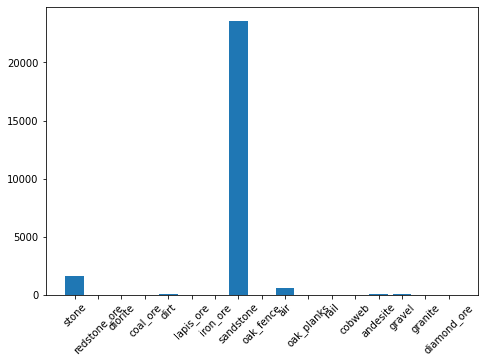

In [12]:
import matplotlib.pyplot as plt
figure = plt.figure()
axes = figure.add_axes([0,0,1,1])
Vec3 = require('vec3').Vec3

columns = bot.world.getColumns()
block_freqs = {}
for c in range(0, 3): # iterate through some of the loaded chunk columns
  cc = columns[c].column
  for y in range(1, 40):
    for x in range(1, 16):
      for z in range(1, 16):
        block = cc.getBlock(Vec3(x, y, z))
        if block.name in block_freqs:
          block_freqs[block.name] += 1
        else:
          block_freqs[block.name] = 1

print(block_freqs)
axes.bar(block_freqs.keys(), block_freqs.values())
plt.xticks(rotation=45)
plt.show()

## Exiting the bot

Once you're done, you can call `bot.quit()` or `bot.end()` to disconnect and stop the bot.

In [13]:
bot.quit()

## Read more

* **API** - https://github.com/PrismarineJS/mineflayer/blob/master/docs/api.md
* **Type Definitions** - https://github.com/PrismarineJS/mineflayer/blob/master/index.d.ts
* FAQ - https://github.com/PrismarineJS/mineflayer/blob/master/docs/FAQ.md
* JS tutorial - https://github.com/PrismarineJS/mineflayer/blob/master/docs/tutorial.md
